<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Exercise_11_3_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 3 - Same as Task 2 but adding PCA(n_components=3) to be fitted on the training
observations and the learned PCA applied to the testing observations, as a feature
engineering step that prepares the input to the low-rank regression model of interest. Plot
the train/test accuracy as in 2.

In [ ]:
%%capture
!pip install nilearn

In [ ]:
%%capture
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib

In [ ]:
%%capture
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression as PLSR
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import BayesianRidge as BR
from sklearn.model_selection import KFold as kf
from sklearn.model_selection import cross_validate

In [ ]:
%%capture
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
# We predefine the models 
plsr    = PLSR(n_components=3, scale=False)
cca     = CCA(n_components=2,  scale=False) 
lda     = LDA(n_components=1)

# We predefine the objects, with the addition of PCA 
scaler  = StandardScaler()
cv   = KFold(n_splits = 5, shuffle = True, random_state = 666)
pca = PCA(n_components = 3)

# We create one pipeline for each model
pipe1 = make_pipeline(scaler, pca, plsr)
pipe2 = make_pipeline(scaler, pca, cca)
pipe3 = make_pipeline(scaler, pca, lda)

In [ ]:
# We define the iterating variable (rois) 
rois = [100,200,300,400,500,600,700,800,900,1000]

# We pre-allocate the variables where we will append the scores
score1_1 = []
score2_1 = []
score3_1 = []
score1_2 = []
score2_2 = []
score3_2 = []

In [ ]:
%%capture
for r in rois:
  brain_data = datasets.fetch_oasis_vbm(n_subjects=(100))
  yeo = datasets.fetch_atlas_schaefer_2018(n_rois=(r)) # We iterate through 100-1000 rois
  masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
  input_variables = masker.fit_transform(brain_data.gray_matter_maps)
  output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females and 0 for males

  X, y = input_variables, output_variable              # We reinstate X, y at the start of the loop in order to reset their values
  y_cont = np.where(y == 0, -1, y)                           # Ditto for the continous version of y (y_cont)

  for train_index, test_index in cv.split(X, y_cont):
      X_train, y_train = X[train_index], y_cont[train_index]
      X_test, y_test = X[test_index], y_cont[test_index]

      plsr_model = pipe1.fit(X_train, y_train)                              # We define the plsr model
      y_train_hat = plsr_model.predict(X_train)                        # We use the fitted model to obtain prediction values on the training data
      y_train_hat = np.where(y_train_hat>0, 1, 0)                   # We re-binarize the prediction values 
      score1 = accuracy_score(y[y_train], y_train_hat)          # We calculate the accuracy between the true labels and the re-binarized predictions
      score1 = np.multiply(score1, 100)                                   # We multiply the scores by 100 to get them in percentage form
      score1_1.append(score1)                                                 # We store the scores
      
      y_test_hat = plsr_model.predict(X_test)                        # We use the fitted model to obtain prediction values on the test data
      y_test_hat = np.where(y_test_hat>0, 1, 0)                   # We re-binarize the prediction values 
      score2 = accuracy_score(y[y_test], y_test_hat)         # We calculate the accuracy between the true labels and the re-binarized predictions
      score2 = np.multiply(score2, 100)                               # We multiply the scores by 100 to get them in percentage form
      score1_2.append(score2)                                             # We store the scores

      cca_model = pipe2.fit(X_train, y_train)                              # We define the cca model
      y_train_hat = cca_model.predict(X_train)                        # We use the fitted model to obtain prediction values on the training data
      y_train_hat = np.where(y_train_hat>0, 1, 0)                   # We re-binarize the prediction values 
      score3 = accuracy_score(y[y_train], y_train_hat)          # We calculate the accuracy between the true labels and the re-binarized predictions
      score3 = np.multiply(score3, 100)                                   # We multiply the scores by 100 to get them in percentage form
      score2_1.append(score3)                                                 # We store the scores
      
      y_test_hat = cca_model.predict(X_test)                         # We use the fitted model to obtain prediction values on the test data
      y_test_hat = np.where(y_test_hat>0, 1, 0)                   # We re-binarize the prediction values 
      score4 = accuracy_score(y[y_test], y_test_hat)         # We calculate the accuracy between the true labels and the re-binarized predictions
      score4 = np.multiply(score4, 100)                               # We multiply the scores by 100 to get them in percentage form
      score2_2.append(score4)                                             # We store the scores

      lda_model = pipe3.fit(X_train, y_train)                               # We define the lda model
      y_train_hat = lda_model.predict(X_train)                         # We use the fitted model to obtain prediction values on the training data
      y_train_hat = np.where(y_train_hat>0, 1, 0)                   # We re-binarize the prediction values 
      score5 = accuracy_score(y[y_train], y_train_hat)          # We calculate the accuracy between the true labels and the re-binarized predictions
      score5 = np.multiply(score5, 100)                                   # We multiply the scores by 100 to get them in percentage form
      score3_1.append(score5)                                                 # We store the scores
      
      y_test_hat = lda_model.predict(X_test)                         # We use the fitted model to obtain prediction values on the test data
      y_test_hat = np.where(y_test_hat>0, 1, 0)                   # We re-binarize the prediction values 
      score6 = accuracy_score(y[y_test], y_test_hat)         # We calculate the accuracy between the true labels and the re-binarized predictions
      score6 = np.multiply(score6, 100)                               # We multiply the scores by 100 to get them in percentage form
      score3_2.append(score6)                                             # We store the scores

In [ ]:
# We convert the output lists into np.arrays and we average by every 5 elements 
plsr_train = np.array(score1_1)
plsr_train = np.average(plsr_train.reshape(-1, 5), axis=1)
plsr_test = np.array(score1_2)
plsr_test = np.average(plsr_test.reshape(-1, 5), axis=1)

cca_train = np.array(score2_1)
cca_train = np.average(cca_train.reshape(-1, 5), axis=1)
cca_test = np.array(score2_2)
cca_test = np.average(cca_test.reshape(-1, 5), axis=1)

lda_train = np.array(score3_1)
lda_train = np.average(lda_train.reshape(-1, 5), axis=1)
lda_test = np.array(score3_2)
lda_test = np.average(lda_test.reshape(-1, 5), axis=1)

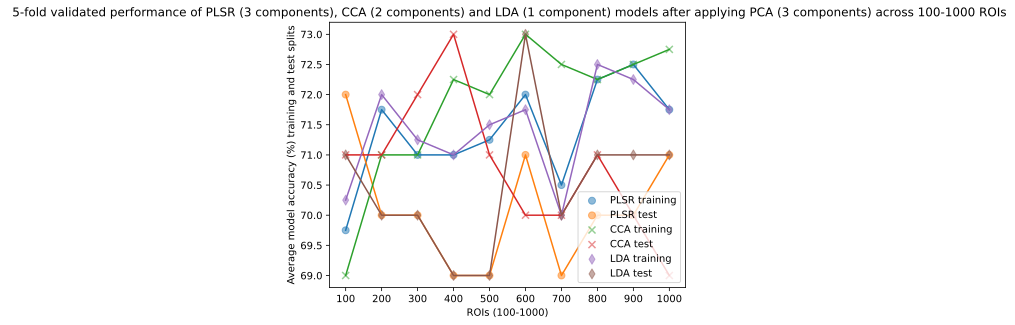

In [ ]:
# We're ready to plot
lab = ['PLSR training', 'PLSR test', 'CCA training', 'CCA test', 'LDA training', 'LDA test']
plt.style.use("default")
plt.scatter(rois,plsr_train, s=50, alpha = 0.5, marker = 'o')
plt.scatter(rois,plsr_test, s=50, alpha = 0.5, marker = 'o')
plt.scatter(rois,cca_train, s=50, alpha = 0.5, marker = 'x')
plt.scatter(rois,cca_test, s=50, alpha = 0.5, marker = 'x')
plt.scatter(rois,lda_train, s=50, alpha = 0.5, marker = 'd')
plt.scatter(rois,lda_test, s=50, alpha = 0.5, marker = 'd')
plt.legend(labels=(lab))
plt.gca().set(
    title=" 5-fold validated performance of PLSR (3 components), CCA (2 components) and LDA (1 component) models after applying PCA (3 components) across 100-1000 ROIs",
    xlabel="ROIs (100-1000)",
    ylabel="Average model accuracy (%) training and test splits",
    xticks = (rois)
)
plt.plot(rois,plsr_train)
plt.plot(rois,plsr_test)
plt.plot(rois,cca_train)
plt.plot(rois,cca_test)
plt.plot(rois,lda_train)
plt.plot(rois,lda_test)
plt.show()